In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from itertools import product
import warnings
import matplotlib.pyplot as plt

In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
svm_results = pd.read_parquet(SVM_SECOND_STAGE_DEMAND_RESULTS_PATH).rename(columns={"mean_fit_time": "train_duration"})
xgboost_results = pd.read_parquet(XGBOOST_SECOND_STAGE_DEMAND_RESULTS_PATH)
nn_results = pd.read_parquet(NN_FOURTH_STAGE_DEMAND_RESULTS_PATH)

In [5]:
svm_results['model'] = 'svm - ' + svm_results['param_kernel']
nn_results['model'] = 'nn'
xgboost_results['model'] = 'xgboost'

In [6]:
relevant_cols = [
	"h3_res",
	"time_interval_length",
	"model",
	"test_mse",
	"test_mae",
	"test_non_zero_mape",
	"test_zero_accuracy",
	"train_duration",
]

In [7]:
results = pd.concat([svm_results[relevant_cols], nn_results[relevant_cols], xgboost_results[relevant_cols]])

In [8]:
results.head(2)

,h3_res,time_interval_length,model,test_mse,test_mae,test_non_zero_mape,test_zero_accuracy,train_duration
0,7,1,svm - poly,2.665077,0.511289,0.448406,0.898903,59.233981
1,7,2,svm - poly,19.301339,1.431508,0.366964,0.811201,106.339026


In [9]:
results.loc[results["h3_res"] == 99, "h3_res"] = 77

In [10]:
def visualize_metric(metric: str, remove_n_worst: int = 0):
	pivoted_results = results.pivot(index=["h3_res", "time_interval_length"], columns='model', values=metric)
	if remove_n_worst > 0:
		pivoted_results['max'] = pivoted_results.max(axis=1)
		pivoted_results = pivoted_results.nsmallest(len(pivoted_results) - remove_n_worst, "max")
		pivoted_results = pivoted_results.drop('max', axis=1)
	pivoted_results.plot(kind="barh", figsize=(8, 8))
	return pivoted_results


model                                nn  svm - poly    xgboost
h3_res time_interval_length                                   
7      1                     186.338808   59.233981   1.257670
       2                     118.628595  106.339026   0.587917
       6                      84.846213  174.270175   0.326107
       24                     51.822149   11.472640   0.148273
8      1                     827.665968  137.719914   8.869535
       2                     439.822626  183.379655   4.662645
       6                     203.167135  216.618685   1.666206
       24                     58.101990  244.099163   0.629647
9      24                    139.595377  562.608911   2.972068
77     24                    492.197467   66.164266  11.415257

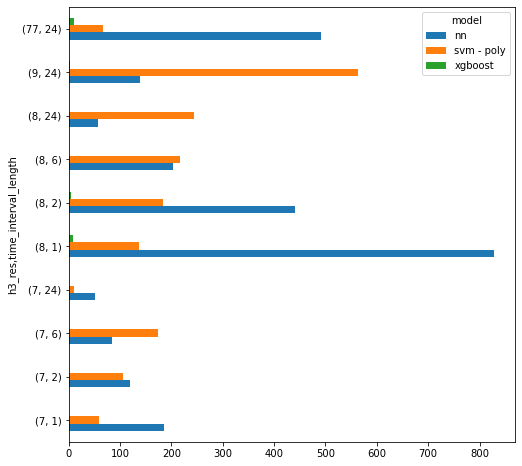

In [11]:
visualize_metric("train_duration")

,model,nn,svm - poly,xgboost
h3_res,time_interval_length,,,
8,1,0.907417,0.512375,0.316263
7,1,2.112337,2.665077,2.107795
8,2,2.682283,3.374197,2.331867
77,24,7.997945,4.138852,2.873258
9,24,8.768210,10.447953,9.846083
8,6,14.918592,16.535265,12.722411
7,2,17.645970,19.301339,16.923856
8,24,44.829146,40.259285,38.277176


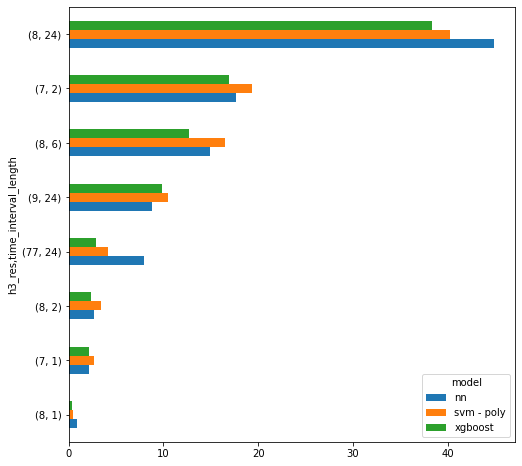

In [18]:
visualize_metric("test_mse", 2)

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.354515    0.511289  0.401879
       2                     1.260489    1.431508  1.211695
       6                     3.922868    3.000653  3.081985
       24                    8.396101    6.656288  6.377749
8      1                     0.161567    0.275154  0.155813
       2                     0.471627    0.646611  0.459649
       6                     1.138881    1.400172  1.179981
       24                    2.685330    2.317048  2.361297
9      24                    1.323776    1.427058  1.481476
77     24                    0.346599    0.380661  0.252244

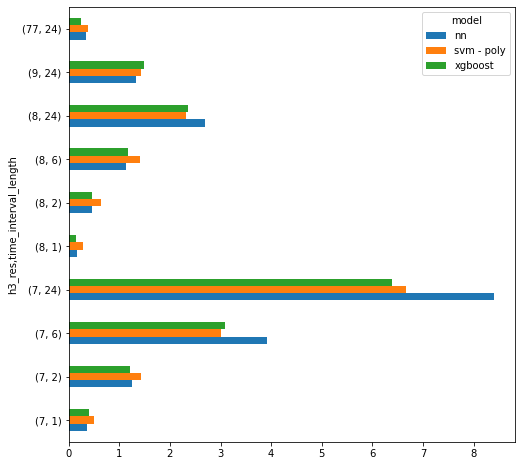

In [20]:
visualize_metric("test_mae")

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.952907    0.898903  0.920896
       2                     0.917816    0.811201  0.889490
       6                     0.239784    0.783393  0.787800
       24                    0.426461    0.790748  0.719595
8      1                     0.939471    0.915995  0.953848
       2                     0.911342    0.859193  0.909112
       6                     0.922531    0.832144  0.868111
       24                    0.344550    0.857496  0.814572
9      24                    0.888043    0.846259  0.798559
77     24                    0.958253    0.925897  0.973002

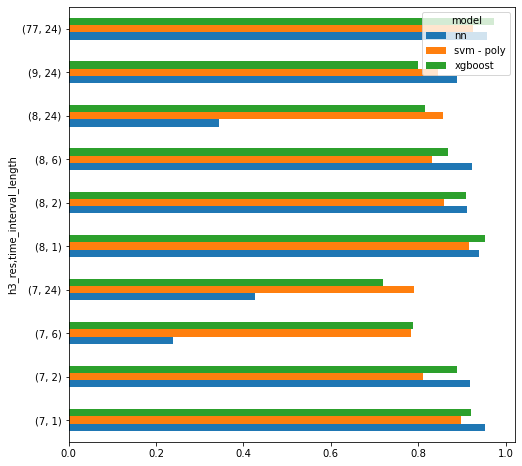

In [21]:
visualize_metric("test_zero_accuracy")

model                              nn  svm - poly   xgboost
h3_res time_interval_length                                
7      1                     0.415404    0.448406  0.389319
       2                     0.358513    0.366964  0.339852
       6                     0.269336    0.220547  0.234628
       24                    0.180705    0.167891  0.159449
8      1                     1.000000    0.622341  0.528939
       2                     0.519434    0.556452  0.473163
       6                     0.415263    0.400860  0.371230
       24                    0.267945    0.250466  0.248011
9      24                    0.407589    0.448487  0.424325
77     24                    0.496868    0.353108  0.318325

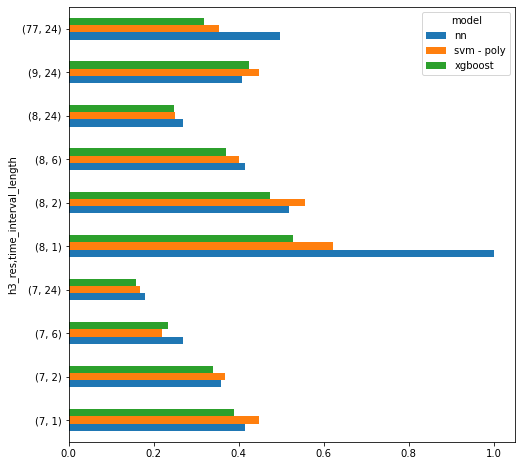

In [22]:
visualize_metric("test_non_zero_mape")

model                                nn  svm - poly     xgboost
h3_res time_interval_length                                    
7      1                       2.112337    2.665077    2.107795
       2                      17.645970   19.301339   16.923856
       6                     121.578570   90.023110   99.559855
       24                    385.978276  384.364754  325.165615
8      1                       0.907417    0.512375    0.316263
       2                       2.682283    3.374197    2.331867
       6                      14.918592   16.535265   12.722411
       24                     44.829146   40.259285   38.277176
9      24                      8.768210   10.447953    9.846083
77     24                      7.997945    4.138852    2.873258